<a href="https://colab.research.google.com/github/Purinkai001/Train/blob/main/Transfer_learning_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install mplcyberpunk

Mounted at /content/drive


In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

# Set style for plots
plt.style.use("cyberpunk")

In [4]:
!unzip /content/drive/MyDrive/Yeehaw_datasets/Brain_tumors.zip -d /content/Brain_tumors

Archive:  /content/drive/MyDrive/Yeehaw_datasets/Brain_tumors.zip
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/Brain_tumors/Testing/glioma_tumor/image(2).jpg  

In [6]:
def load_dataset(path):
    file_list = []
    try:
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                file_list.append(os.path.join(dirname, filename))
    except Exception as e:
        print(e)
    return file_list

samp = load_dataset('/content/Brain_tumors')
samp[:5]

['/content/Brain_tumors/Testing/glioma_tumor/image(44).jpg',
 '/content/Brain_tumors/Testing/glioma_tumor/image(15).jpg',
 '/content/Brain_tumors/Testing/glioma_tumor/image(98).jpg',
 '/content/Brain_tumors/Testing/glioma_tumor/image(7).jpg',
 '/content/Brain_tumors/Testing/glioma_tumor/image(31).jpg']

In [7]:
TRAINING_PATH = '/content/Brain_tumors/Training'
TESTING_PATH = '/content/Brain_tumors/Testing'
LABELS = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
IMAGE_SIZE = 144


def load_images_from_folder(folder_path, labels, image_size):
    """Load and preprocess images from specified folder path."""
    X = []
    y = []

    for label in labels:
        label_folder_path = os.path.join(folder_path, label)


        if not os.path.exists(label_folder_path):
            print(f"Warning: {label_folder_path} does not exist.")
            continue

        for filename in tqdm(os.listdir(label_folder_path), desc=f"Loading {label} images"):
            img_path = os.path.join(label_folder_path, filename)


            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(X), np.array(y)


X_train, y_train = load_images_from_folder(TRAINING_PATH, LABELS, IMAGE_SIZE)
X_test, y_test = load_images_from_folder(TESTING_PATH, LABELS, IMAGE_SIZE)


print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Loading pituitary_tumor images: 100%|██████████| 74/74 [00:00<00:00, 276.57it/s]

Training data shape: (2870, 144, 144, 3), Training labels shape: (2870,)
Testing data shape: (394, 144, 144, 3), Testing labels shape: (394,)


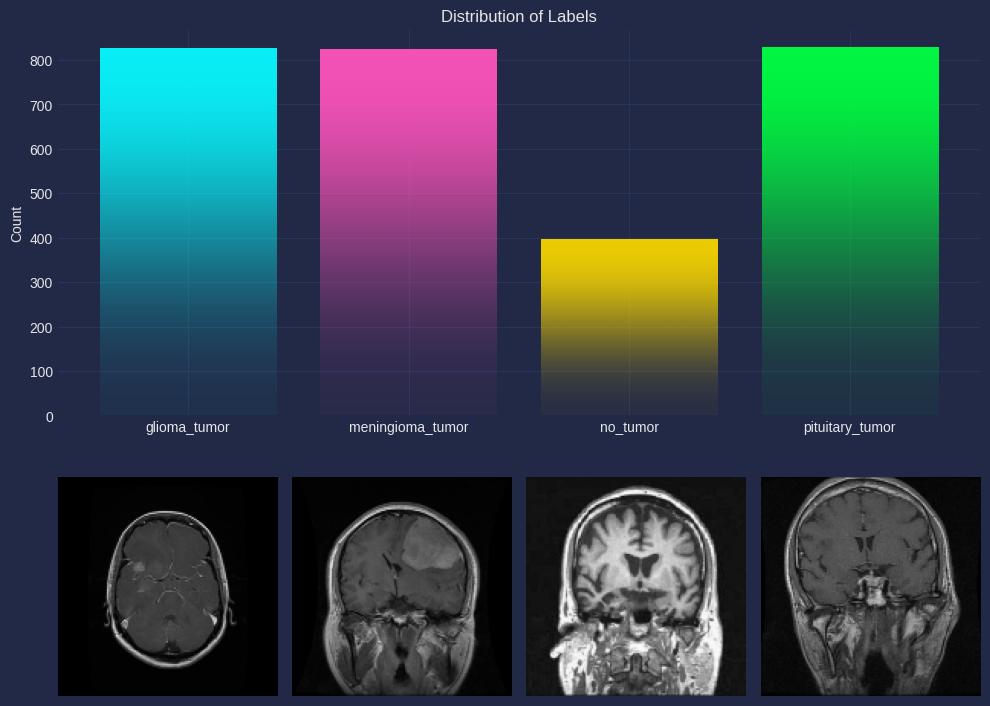

In [8]:
import matplotlib.pyplot as plt
import mplcyberpunk

def plot_label_distribution_and_samples(X, y, labels, num_samples=1, colors=None):

    label_counts = {label: np.sum(y == label) for label in labels}


    if colors is None:
        colors = ["C0", "C1", "C2", "C3"]


    plt.figure(figsize=(10, 8))


    plt.subplot(2, 1, 1)
    bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
    mplcyberpunk.add_bar_gradient(bars=bars)
    plt.ylabel('Count')
    plt.title('Distribution of Labels')


    for k, label in enumerate(labels):
        count = 0
        for j in range(len(y)):
            if y[j] == label and count < num_samples:
                plt.subplot(2, 4, k + 5)
                plt.imshow(X[j])
                plt.axis('off')
                count += 1

    plt.tight_layout()
    plt.show()


plot_label_distribution_and_samples(X_train, y_train, LABELS, num_samples=2)

In [9]:
def preprocess_data(X: np.ndarray, y: np.ndarray, labels: list, test_size: float = 0.2, random_state: int = 101) -> tuple:

    X, y = shuffle(X, y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    y_train = tf.keras.utils.to_categorical([labels.index(label) for label in y_train])
    y_test = tf.keras.utils.to_categorical([labels.index(label) for label in y_test])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(X_train, y_train, LABELS)
y_train.shape, y_test.shape

((2296, 4), (574, 4))

In [14]:
X_train[0][50][50]

array([54, 54, 54], dtype=uint8)

In [15]:
efficientnetB0 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)


x = efficientnetB0.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(len(LABELS), activation='softmax')(x)

model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs=x)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 144, 144, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 144, 144, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 144, 144, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 144, 144, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 145, 145, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 72, 72, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 72, 72, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 72, 72, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 72, 72, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 72, 72, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 72, 72, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [16]:
tensorboard_callback = TensorBoard(log_dir='logs')

checkpoint_callback = ModelCheckpoint(
    filepath="efficientnetB0.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    min_delta=0.0001,
    verbose=1
)

In [17]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback, checkpoint_callback, reduce_lr_callback]
)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7507 - loss: 0.6574
Epoch 1: val_accuracy improved from -inf to 0.83478, saving model to efficientnetB0.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.7520 - loss: 0.6546 - val_accuracy: 0.8348 - val_loss: 0.9253 - learning_rate: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9223 - loss: 0.2125
Epoch 2: val_accuracy did not improve from 0.83478
65/65 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9222 - loss: 0.2126 - val_accuracy: 0.8304 - val_loss: 1.2068 - learning_rate: 0.0010
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9622 - loss: 0.1252
Epoch 3: val_accuracy improved from 0.83478 to 0.83913, saving model to efficientnetB0.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9621 - loss: 0.1255 - val_accuracy: 0.8391 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9728 - loss: 0.1008
Epoch 4: val_a

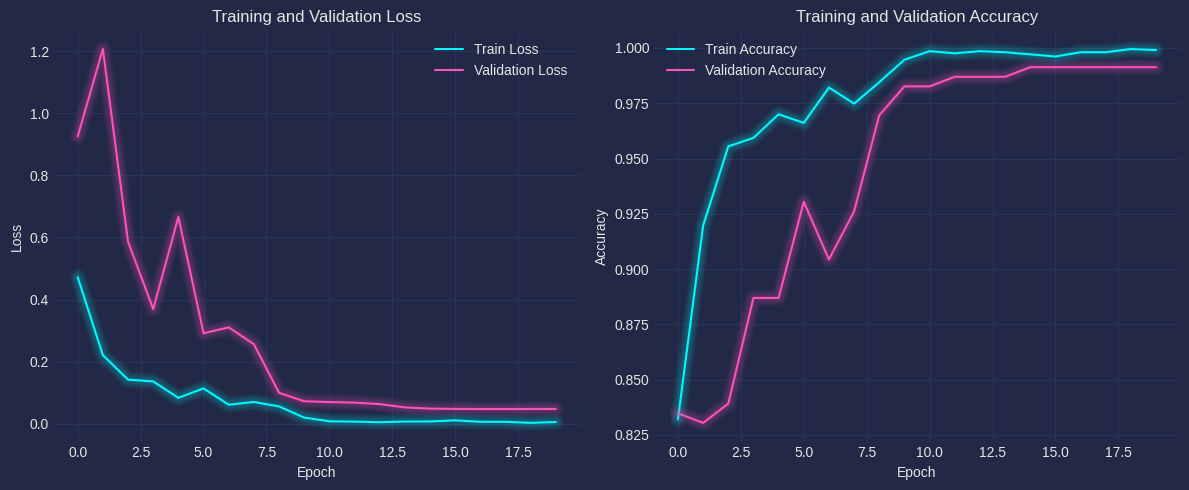

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 806ms/step


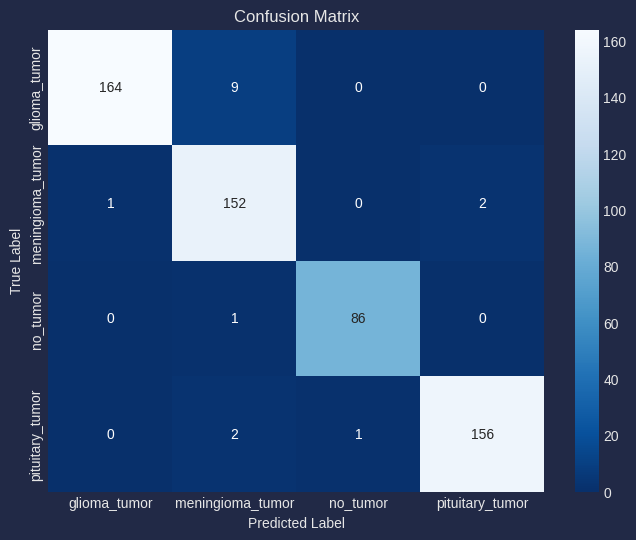

In [19]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)


plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    confusion_matrix(y_true_test, y_pred_test),
    annot=True,
    fmt='d',
    cmap='Blues_r',
    xticklabels=LABELS,
    yticklabels=LABELS
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       173
           1       0.93      0.98      0.95       155
           2       0.99      0.99      0.99        87
           3       0.99      0.98      0.98       159

    accuracy                           0.97       574
   macro avg       0.97      0.97      0.97       574
weighted avg       0.97      0.97      0.97       574

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted label (Image 1): meningioma_tumor
Actual label (Image 1): meningioma_tumor
Confidence (Image 1): 99.99%

Predicted label (Image 2): pituitary_tumor
Actual label (Image 2): pituitary_tumor
Confidence (Image 2): 100.00%

Predicted label (Image 3): pituitary_tumor
Actual label (Image 3): pituitary_tumor
Confidence (Image 3): 100.00%



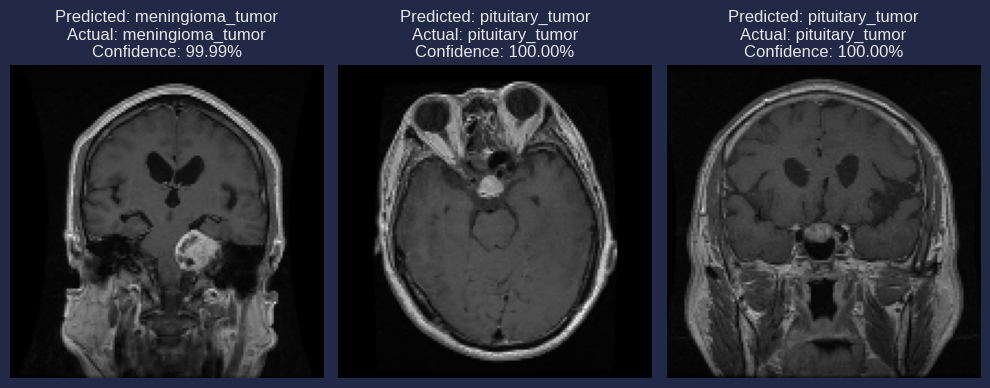

In [20]:
print(classification_report(y_true_test, y_pred_test))
random_indices = np.random.choice(len(X_test), size=3, replace=False)
random_imgs = X_test[random_indices]
predictions = model.predict(random_imgs.reshape(3, IMAGE_SIZE, IMAGE_SIZE, 3))


predicted_labels = []
actual_labels = []
confidences = []


for i in range(3):
    predicted_class = np.argmax(predictions[i])
    predicted_labels.append(LABELS[predicted_class])
    confidences.append(predictions[i][predicted_class])

    actual_index = y_test[random_indices[i]]
    actual_class = np.argmax(actual_index)
    actual_labels.append(LABELS[actual_class])

for i in range(3):
    print(f"\033[94mPredicted label (Image {i+1}): {predicted_labels[i]}\033[0m")
    print(f"\033[92mActual label (Image {i+1}): {actual_labels[i]}\033[0m")
    print(f"\033[93mConfidence (Image {i+1}): {confidences[i] * 100:.2f}%\033[0m\n")


plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(random_imgs[i])
    plt.axis('off')
    plt.title(f"Predicted: {predicted_labels[i]}\nActual: {actual_labels[i]}\nConfidence: {confidences[i] * 100:.2f}%")
plt.tight_layout()
plt.show()

